# Italian Financial Challenge - Starter Template

**Student Name:** [Your Name]

**Challenge:** [Choose: Bankruptcy Prediction / Financial Health Classification / Revenue Forecasting]

**Date:** [Date]

---

## Instructions

This template provides a suggested structure for your challenge solution. You can adapt it to your needs, but make sure to cover all required sections:

1. Problem Statement and Objectives
2. Data Loading and Exploration
3. Data Preprocessing
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Interpretation and Business Insights
8. Conclusions and Future Work

**Remember:**
- Document your thought process with markdown cells
- Comment your code clearly
- Create visualizations to support your insights
- Interpret results in business terms
- Check the evaluation rubric to ensure you meet all criteria

## 1. Problem Statement and Objectives

**Challenge:** [Describe which challenge you chose and why]

**Objective:** [State the prediction goal clearly]

**Success Criteria:** [Define what "good" performance looks like for your chosen challenge]

**Approach:** [Briefly outline your planned approach]

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# Create images folder for saved plots
IMAGES_DIR = Path('images')
IMAGES_DIR.mkdir(exist_ok=True)

def save_fig(name, dpi=150):
    path = IMAGES_DIR / f"{name}.png"
    plt.savefig(path, dpi=dpi, bbox_inches="tight")



Libraries imported successfully!


## 2. Data Loading and Exploration (EDA for Challenge 3: Revenue Forecasting)

This EDA is leakage-safe and follows the required order:
1. Dataset Overview
2. Target Variable Analysis
3. Missing Values Analysis
4. Outlier Analysis
5. Univariate Feature Analysis
6. Feature <-> Target Relationships
7. Multicollinearity & Redundancy
8. Feature Grouping
9. Data Leakage Audit
10. EDA -> Modeling Implications


### 1. Dataset Overview


In [2]:
# Load training data
train_df = pd.read_csv('../data/processed/train_data.csv')

# Explicit target definition for Challenge 3
target_col = 'revenue_change'
target_definition = "Percent change in production_value vs prior year"
target_units = "percentage (%)"

# Columns that are coded as numeric but represent categories
categorical_like_cols = ['ateco_sector'] if 'ateco_sector' in train_df.columns else []

print(f"Dataset shape (rows, cols): {train_df.shape}")
print(f"Unique companies: {train_df['company_id'].nunique()}")
print(f"Fiscal year range: {train_df['fiscal_year'].min()} - {train_df['fiscal_year'].max()}")
print(f"Target: {target_col} ({target_units}) - {target_definition}")

print(f"Columns ({len(train_df.columns)}):")
print(train_df.columns.tolist())
print("First few rows:")
train_df.head()
# Analysis: verify years/columns match documentation; no filtering applied.


Dataset shape (rows, cols): (11828, 30)
Unique companies: 2999
Fiscal year range: 2018 - 2021
Target: revenue_change (percentage (%)) - Percent change in production_value vs prior year
Columns (30):
['company_id', 'fiscal_year', 'province', 'region', 'ateco_sector', 'legal_form', 'years_in_business', 'total_fixed_assets', 'current_assets', 'total_assets', 'shareholders_equity', 'total_debt', 'short_term_debt', 'long_term_debt', 'production_value', 'production_costs', 'operating_income', 'financial_income', 'financial_expenses', 'net_profit_loss', 'roe', 'roi', 'leverage', 'current_ratio', 'quick_ratio', 'debt_to_assets', 'profit_margin', 'bankruptcy_next_year', 'financial_health_class', 'revenue_change']
First few rows:


,company_id,fiscal_year,province,region,ateco_sector,legal_form,years_in_business,total_fixed_assets,current_assets,total_assets,shareholders_equity,total_debt,short_term_debt,long_term_debt,production_value,production_costs,operating_income,financial_income,financial_expenses,net_profit_loss,roe,roi,leverage,current_ratio,quick_ratio,debt_to_assets,profit_margin,bankruptcy_next_year,financial_health_class,revenue_change
0,COMP_00000,2018,NaN,Campania,47,SRL,32,2.422343e+08,9.504819e+08,1.192716e+09,3.728702e+08,8.198459e+08,5.601842e+08,2.596617e+08,1.846636e+09,1.611363e+09,2.352729e+08,4886785.12,20068071.29,2.152049e+08,0.5772,0.1973,2.1987,1.6967,1.0180,0.6874,0.1165,0,B,NaN
1,COMP_00000,2019,NaN,Campania,47,SRL,33,3.983639e+07,1.411226e+08,1.809589e+08,5.700701e+07,1.239519e+08,7.135345e+07,5.259848e+07,4.289159e+08,3.896038e+08,3.931218e+07,58246.06,2537224.20,3.677495e+07,0.6451,0.2172,2.1743,1.9778,1.1867,0.6850,0.0857,0,B,-76.77
2,COMP_00000,2020,NaN,Campania,47,SRL,34,6.662250e+08,1.367208e+09,2.033433e+09,3.029046e+08,1.730529e+09,9.904004e+08,7.401282e+08,6.956197e+09,6.988489e+09,-3.229208e+07,5327332.51,55844558.38,-8.813664e+07,-0.2910,-0.0159,5.7131,1.3805,0.8283,0.8510,-0.0127,0,D,1521.81
3,COMP_00000,2021,NaN,Campania,47,SRL,35,4.637187e+07,2.524228e+08,2.987947e+08,3.901098e+07,2.597837e+08,1.527674e+08,1.070163e+08,5.031839e+08,5.047235e+08,-1.539645e+06,116335.80,7828741.61,-9.368387e+06,-0.2401,-0.0052,6.6592,1.6523,0.9914,0.8694,-0.0186,0,D,-92.77
4,COMP_00001,2018,CA,Sardegna,62,SRL,8,8.348035e+07,1.325697e+08,2.160500e+08,6.566937e+07,1.503807e+08,7.582482e+07,7.455584e+07,4.113380e+08,3.912414e+08,2.009667e+07,640538.94,5860639.22,1.423603e+07,0.2168,0.0930,2.2900,1.7484,1.0490,0.6960,0.0346,0,B,NaN


In [3]:
# Basic information
train_df.info()

# Feature type breakdown
id_cols = ['company_id']
time_cols = ['fiscal_year']
other_target_cols = ['bankruptcy_next_year', 'financial_health_class']

numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

numeric_features = [
    c for c in numeric_cols
    if c not in id_cols + time_cols + [target_col] + ['bankruptcy_next_year'] + categorical_like_cols
]

categorical_features = [c for c in categorical_cols if c not in id_cols + ['financial_health_class']]
for c in categorical_like_cols:
    if c not in categorical_features:
        categorical_features.append(c)

print("Feature type counts:")
print(f"Identifiers: {id_cols}")
print(f"Time columns: {time_cols}")
print(f"Target column: {target_col}")
print(f"Other target cols to exclude: {other_target_cols}")
print(f"Numeric feature cols: {len(numeric_features)}")
print(f"Categorical feature cols: {len(categorical_features)}")
print(f"Total usable feature cols: {len(numeric_features) + len(categorical_features)}")
print(f"Memory usage (MB): {train_df.memory_usage(deep=True).sum() / 1e6:.2f}")
# Analysis: confirm dtypes and identify any unexpected categorical/numeric encodings.


<class 'pandas.DataFrame'>
RangeIndex: 11828 entries, 0 to 11827
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_id              11828 non-null  str    
 1   fiscal_year             11828 non-null  int64  
 2   province                10909 non-null  str    
 3   region                  11828 non-null  str    
 4   ateco_sector            11828 non-null  int64  
 5   legal_form              11828 non-null  str    
 6   years_in_business       11828 non-null  int64  
 7   total_fixed_assets      11828 non-null  float64
 8   current_assets          11828 non-null  float64
 9   total_assets            11828 non-null  float64
 10  shareholders_equity     11828 non-null  float64
 11  total_debt              11828 non-null  float64
 12  short_term_debt         11828 non-null  float64
 13  long_term_debt          11828 non-null  float64
 14  production_value        11828 non-null  float64
 

**Units and domain assumptions:**
- Monetary columns represent annual values in euros.
- Ratio columns are unitless and may be negative when equity/profit is negative.
- `revenue_change` is a percentage (%) based on year-over-year production_value.


### 2. Target Variable Analysis


Revenue Change Summary:


count      8829.000000
mean        453.434570
std        4601.920625
min         -99.940000
25%         -68.590000
50%           3.040000
75%         238.850000
max      302126.480000
Name: revenue_change, dtype: float64

Missing revenue_change: 2999 (25.36%)
Skewness: 47.298
Kurtosis: 2707.068
Quantiles (1%, 5%, 50%, 95%, 99%):
0.01     -98.5844
0.05     -94.4760
0.50       3.0400
0.95    1755.8420
0.99    6313.3136
Name: revenue_change, dtype: float64


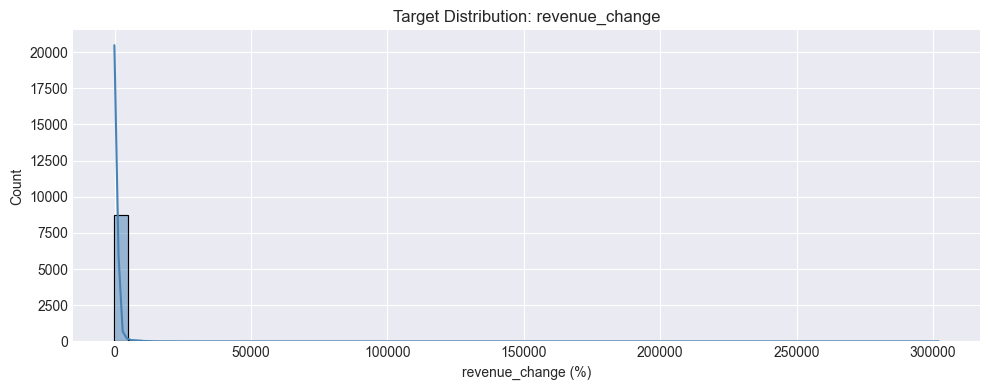

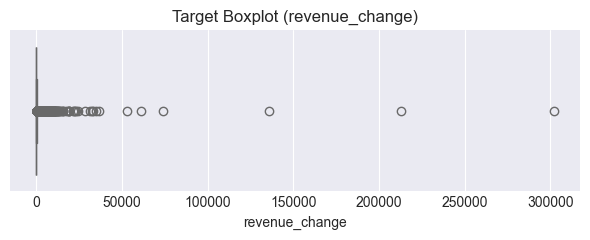

In [4]:
# Target variable analysis
# TODO: Uncomment the relevant section for your challenge

# For Challenge 1: Bankruptcy Prediction
# print("\nBankruptcy Distribution:")
# print(train_df['bankruptcy_next_year'].value_counts())
# print(f"\nBankruptcy rate: {train_df['bankruptcy_next_year'].mean():.2%}")

# For Challenge 2: Financial Health Classification
# print("\nFinancial Health Distribution:")
# print(train_df['financial_health_class'].value_counts().sort_index())
# print("\nPercentages:")
# print(train_df['financial_health_class'].value_counts(normalize=True).sort_index())

# For Challenge 3: Revenue Forecasting
# print("\nRevenue Change Statistics:")
# print(train_df['revenue_change'].describe())
# print(f"\nMissing revenue_change: {train_df['revenue_change'].isnull().sum()}")

# Challenge 3 target analysis (no transformations applied)
target_series = train_df[target_col]

print("Revenue Change Summary:")
display(target_series.describe())
print(f"Missing {target_col}: {target_series.isna().sum()} ({target_series.isna().mean():.2%})")

skew_val = target_series.dropna().skew()
kurt_val = target_series.dropna().kurtosis()
print(f"Skewness: {skew_val:.3f}")
print(f"Kurtosis: {kurt_val:.3f}")

quantiles = target_series.dropna().quantile([0.01, 0.05, 0.50, 0.95, 0.99])
print("Quantiles (1%, 5%, 50%, 95%, 99%):")
print(quantiles)

plt.figure(figsize=(10, 4))
sns.histplot(target_series, bins=60, kde=True, color='steelblue')
plt.title('Target Distribution: revenue_change')
plt.xlabel('revenue_change (%)')
plt.tight_layout()
save_fig('target_hist')
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=target_series, color='tan')
plt.title('Target Boxplot (revenue_change)')
plt.tight_layout()
save_fig('target_boxplot')
plt.show()

# Analysis note: no transformation applied here; evaluate log/robust transforms after EDA if skew is extreme.


### 3. Missing Values Analysis


Missing Values:


,Missing Count,Percentage
revenue_change,2999,25.355090
province,919,7.769699
roe,45,0.380453
leverage,45,0.380453


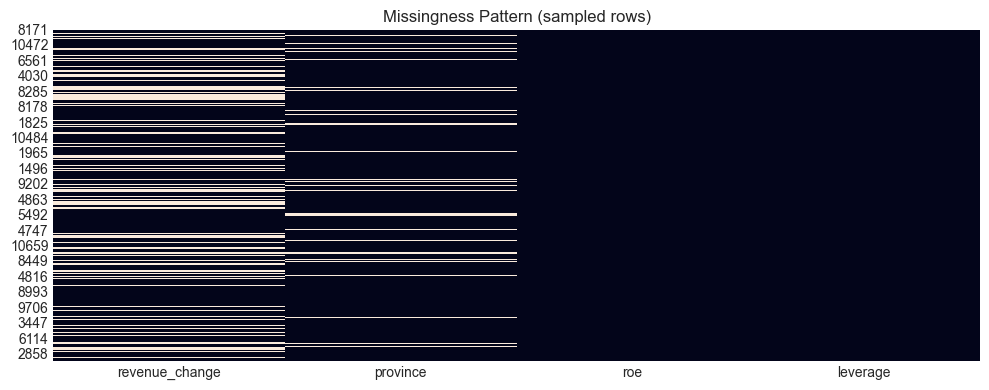

Missingness rate by fiscal_year:
revenue_change:
fiscal_year
2018    1.000000
2019    0.012756
2020    0.000000
2021    0.000000
Name: revenue_change, dtype: float64
province:
fiscal_year
2018    0.077001
2019    0.077878
2020    0.077808
2021    0.078104
Name: province, dtype: float64
roe:
fiscal_year
2018    0.004053
2019    0.003693
2020    0.004060
2021    0.003411
Name: roe, dtype: float64
leverage:
fiscal_year
2018    0.004053
2019    0.003693
2020    0.004060
2021    0.003411
Name: leverage, dtype: float64


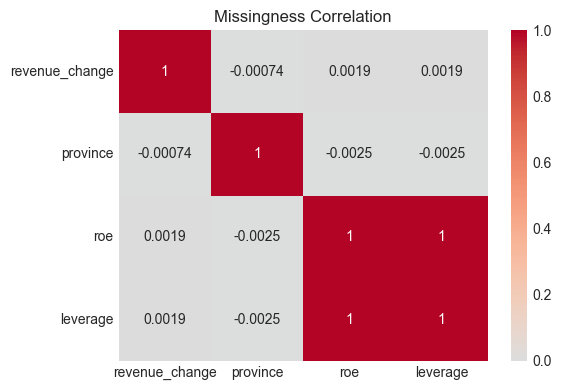

In [5]:
# Check for missing values
missing_values = train_df.isnull().sum()
missing_pct = (missing_values / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Values:")
display(missing_df)

# Missingness pattern (sampled rows for readability)
if not missing_df.empty:
    missing_cols = missing_df.index.tolist()
    sample = train_df[missing_cols].isna()
    sample_rows = sample.sample(min(300, len(sample)), random_state=RANDOM_STATE)
    plt.figure(figsize=(10, 4))
    sns.heatmap(sample_rows, cbar=False)
    plt.title('Missingness Pattern (sampled rows)')
    plt.tight_layout()
    save_fig('missingness_pattern')
    plt.show()

    # Missingness by year for key columns (no target-based conditioning)
    print("Missingness rate by fiscal_year:")
    for col in missing_cols:
        rate_by_year = train_df.groupby('fiscal_year')[col].apply(lambda s: s.isna().mean())
        print(f"{col}:")
        print(rate_by_year)

    # Missingness correlation between columns (if multiple missing columns exist)
    if len(missing_cols) > 1:
        miss_ind = train_df[missing_cols].isna().astype(int)
        miss_corr = miss_ind.corr()
        plt.figure(figsize=(6, 4))
        sns.heatmap(miss_corr, annot=True, cmap='coolwarm', center=0)
        plt.title('Missingness Correlation')
        plt.tight_layout()
        save_fig('missingness_correlation')
        plt.show()
# Analysis: assess whether missingness is systematic or informative; consider indicators later.


### 4. Outlier Analysis


Top 15 features by IQR outlier percentage:


,feature,outlier_count,outlier_pct,iqr_lower,iqr_upper
13,net_profit_loss,1526,12.901589,-1.577999e+08,2.909778e+08
11,financial_income,1461,12.352046,-3.875413e+06,7.410901e+06
10,operating_income,1457,12.318228,-1.882437e+08,3.590361e+08
1,total_fixed_assets,1447,12.233683,-6.268161e+08,1.239888e+09
4,shareholders_equity,1438,12.157592,-5.766513e+08,1.149630e+09
9,production_costs,1433,12.115320,-2.430077e+09,4.778472e+09
5,total_debt,1433,12.115320,-9.956016e+08,2.004575e+09
12,financial_expenses,1428,12.073047,-3.419748e+07,6.860966e+07
8,production_value,1427,12.064592,-2.615524e+09,5.155175e+09
6,short_term_debt,1425,12.047683,-5.434543e+08,1.090440e+09


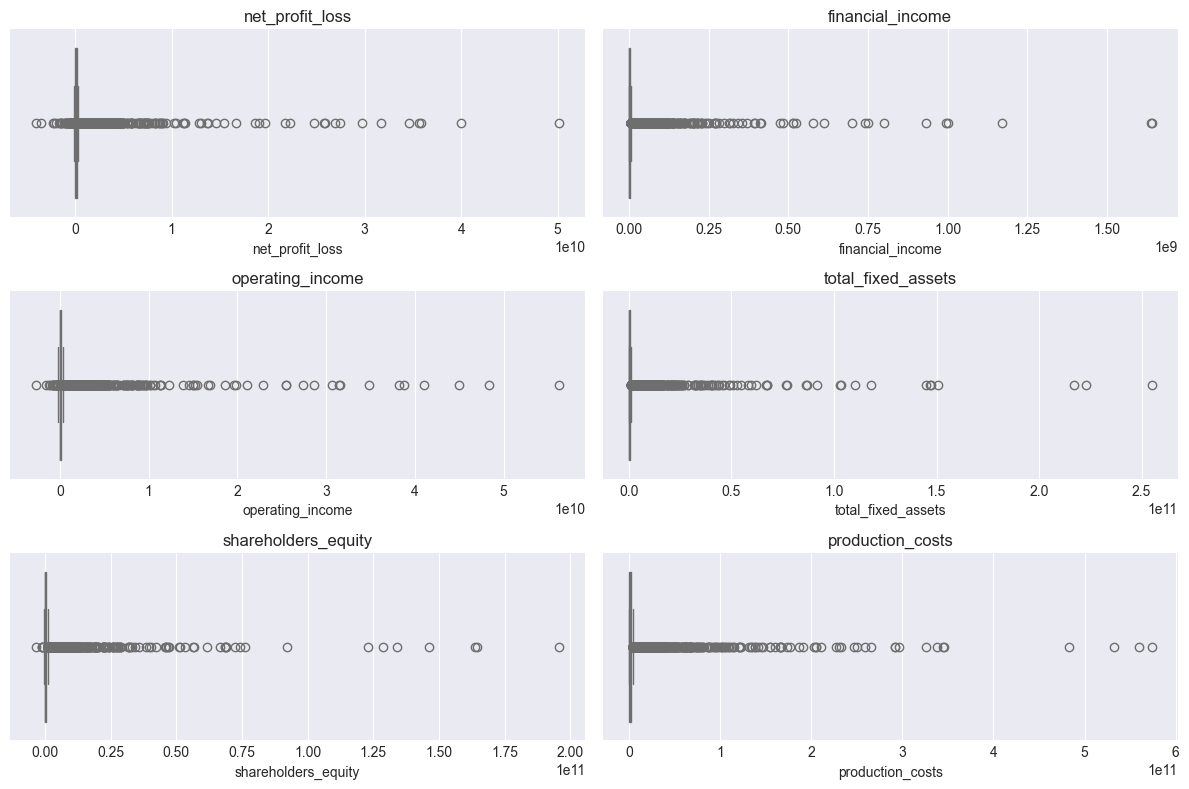

In [6]:
# Outlier analysis using IQR and percentile rules (features only)
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

outlier_stats = []
for col in numeric_features:
    s = train_df[col].dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outlier_mask = (s < lower) | (s > upper)
    outlier_stats.append({
        'feature': col,
        'outlier_count': int(outlier_mask.sum()),
        'outlier_pct': float(outlier_mask.mean() * 100),
        'iqr_lower': float(lower),
        'iqr_upper': float(upper)
    })

outlier_df = pd.DataFrame(outlier_stats).sort_values('outlier_pct', ascending=False)
print("Top 15 features by IQR outlier percentage:")
display(outlier_df.head(15))

# Boxplots for the most outlier-prone features (top 6)
top_outlier_cols = outlier_df['feature'].head(6).tolist()
if len(top_outlier_cols) > 0:
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    axes = axes.flatten()
    for ax, col in zip(axes, top_outlier_cols):
        sns.boxplot(x=train_df[col], ax=ax, color='lightcoral')
        ax.set_title(col)
    plt.tight_layout()
    save_fig('outlier_boxplots_top6')
    plt.show()

# Analysis note: outliers are not removed here; treatment decisions are deferred to preprocessing.


### 5. Univariate Feature Analysis


Numeric feature summary (top 15 by absolute skewness):


,count,mean,std,min,1%,5%,50%,95%,99%,max,skew,kurtosis
roe,11783.0,2.542670e-01,5.773738e-01,-3.917710e+01,-3.250340e-01,-8.027000e-02,2.216000e-01,7.489600e-01,1.097620e+00,1.771600e+00,-40.422273,2384.667402
financial_income,11828.0,6.418314e+06,3.930832e+07,6.241000e+01,1.326179e+04,6.204681e+04,1.068330e+06,1.919989e+07,9.860690e+07,1.640114e+09,23.181067,733.159874
total_fixed_assets,11828.0,1.029206e+09,6.120958e+09,1.267167e+06,8.501086e+06,1.923217e+07,1.905995e+08,2.996818e+09,1.359812e+10,2.548712e+11,22.783542,694.444570
shareholders_equity,11828.0,9.163141e+08,5.023564e+09,-3.330561e+09,6.388691e+06,1.842910e+07,1.815958e+08,2.896381e+09,1.294370e+10,1.956145e+11,21.015325,590.560191
short_term_debt,11828.0,8.534656e+08,4.360360e+09,8.985461e+05,8.562312e+06,2.012226e+07,1.744802e+08,2.731549e+09,1.251086e+10,1.699685e+11,19.858400,550.538204
leverage,11783.0,2.135329e+00,2.159040e+00,8.182000e-01,8.284000e-01,8.749600e-01,1.680300e+00,5.215580e+00,8.165520e+00,1.011538e+02,19.163238,679.864449
total_assets,11828.0,2.467641e+09,1.248305e+10,2.545968e+06,2.691591e+07,6.093473e+07,5.212379e+08,7.813904e+09,3.472548e+10,5.061262e+11,19.025165,500.609619
net_profit_loss,11828.0,2.342839e+08,1.348222e+09,-4.062689e+09,-1.028847e+08,-6.932124e+06,3.798727e+07,7.590478e+08,3.629124e+09,5.011818e+10,18.931243,472.490686
long_term_debt,11828.0,6.978617e+08,3.493369e+09,9.412449e+05,6.897902e+06,1.577708e+07,1.462585e+08,2.216771e+09,9.741234e+09,1.405431e+11,18.804574,495.862491
operating_income,11828.0,2.889337e+08,1.574126e+09,-2.688184e+09,-3.091586e+07,1.708474e+06,5.128590e+07,9.251195e+08,4.258067e+09,5.621927e+10,18.781624,463.453174


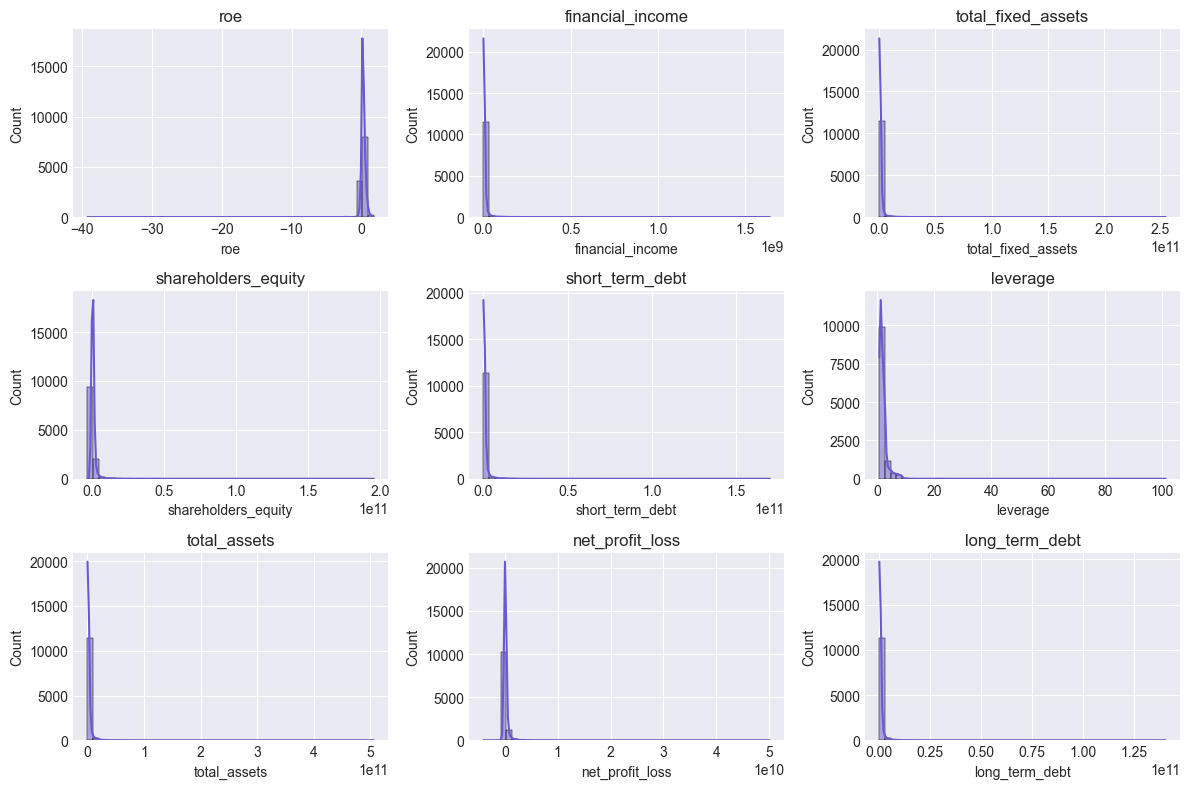

In [7]:
# Summary statistics
# Numeric features only (exclude targets and identifiers)
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

summary = train_df[numeric_features].describe(percentiles=[0.01, 0.05, 0.50, 0.95, 0.99]).T
summary['skew'] = train_df[numeric_features].skew()
summary['kurtosis'] = train_df[numeric_features].kurtosis()

print("Numeric feature summary (top 15 by absolute skewness):")
display(summary.reindex(summary['skew'].abs().sort_values(ascending=False).index).head(15))

# Visualize distributions for the most skewed numeric features
skewed_cols = summary['skew'].abs().sort_values(ascending=False).head(9).index.tolist()
if len(skewed_cols) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(12, 8))
    axes = axes.flatten()
    for ax, col in zip(axes, skewed_cols):
        sns.histplot(train_df[col], bins=50, kde=True, ax=ax, color='slateblue')
        ax.set_title(col)
    plt.tight_layout()
    save_fig('skewed_numeric_distributions')
    plt.show()
# Analysis: review skewness/kurtosis to plan robust scaling or transformations.


province - unique: 19
province
MI     2266
RM     1883
NaN     919
TO      796
FI      721
BO      656
PA      627
BA      478
VE      446
GE      401
Name: count, dtype: int64
Rare categories (<1%): 0
region - unique: 13
region
Lombardia         2516
Lazio             1883
Emilia-Romagna    1389
Veneto            1168
Campania           919
Sicilia            898
Piemonte           796
Toscana            721
Puglia             478
Liguria            401
Name: count, dtype: int64
Rare categories (<1%): 0
legal_form - unique: 5
legal_form
SRL     8563
SPA     1570
SAS      902
SNC      614
SAPA     179
Name: count, dtype: int64
Rare categories (<1%): 0
ateco_sector - unique: 13
ateco_sector
46    1688
47    1491
41    1465
43    1189
25    1095
10     958
62     950
56     754
45     662
71     546
Name: count, dtype: int64
Rare categories (<1%): 0


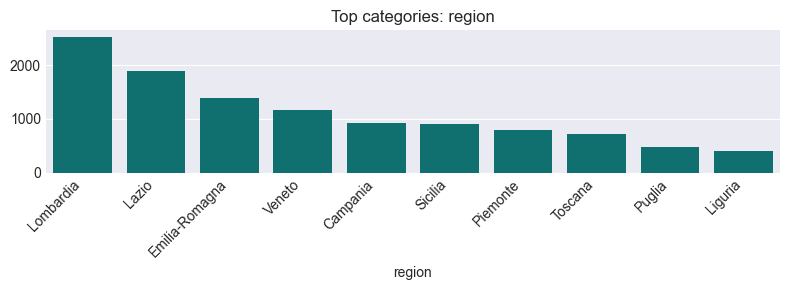

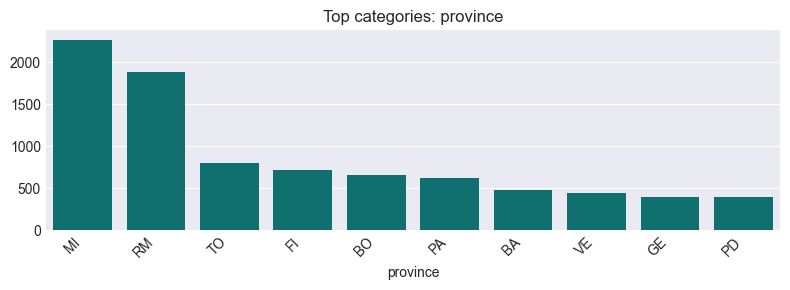

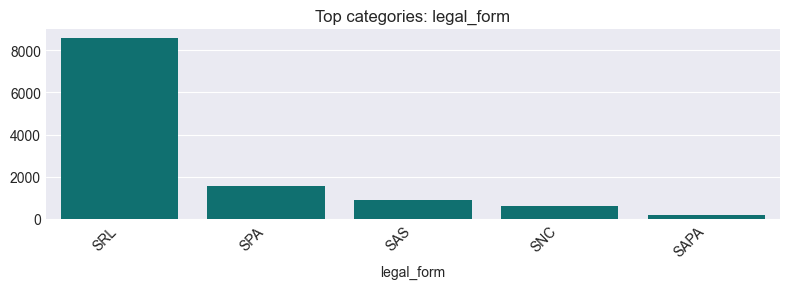

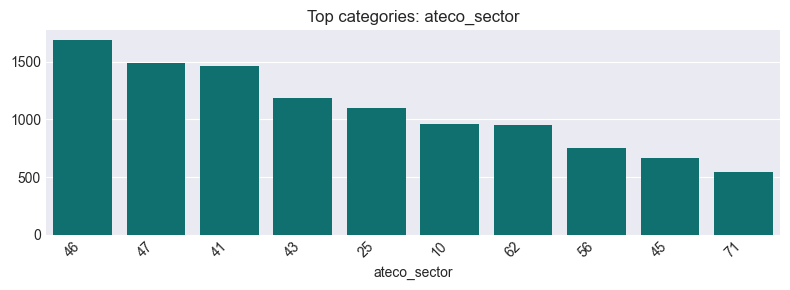

In [8]:
# Categorical feature frequency analysis
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

# Include numeric-coded categorical columns
categorical_features = [c for c in categorical_cols if c not in ['company_id', 'financial_health_class']]
for c in categorical_like_cols:
    if c not in categorical_features:
        categorical_features.append(c)

for col in categorical_features:
    vc = train_df[col].value_counts(dropna=False)
    pct = vc / len(train_df) * 100
    print(f"{col} - unique: {train_df[col].nunique(dropna=True)}")
    print(vc.head(10))

    rare = pct[pct < 1.0]
    print(f"Rare categories (<1%): {len(rare)}")

# Example bar plots for top categories
plot_cols = [c for c in ['region', 'province', 'legal_form', 'ateco_sector'] if c in categorical_features]
for col in plot_cols:
    top = train_df[col].value_counts().head(10)
    plt.figure(figsize=(8, 3))
    sns.barplot(x=top.index.astype(str), y=top.values, color='teal')
    plt.title(f'Top categories: {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    save_fig(f'top_categories_{col}')
    plt.show()
# Analysis: inspect rare categories for grouping or target encoding decisions later.


### 6. Feature <-> Target Relationships


Top 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
production_value,0.170943,0.560179
production_costs,0.170918,0.559152
total_assets,0.169760,0.552148
current_assets,0.177701,0.549282
total_debt,0.172818,0.547521
short_term_debt,0.169686,0.544644
long_term_debt,0.170591,0.541096
financial_expenses,0.174653,0.535138
shareholders_equity,0.159066,0.530878
total_fixed_assets,0.147850,0.527453


Bottom 10 numeric features by absolute Spearman correlation with target:


,pearson,spearman
financial_income,0.148976,0.458827
net_profit_loss,0.151149,0.432072
roe,0.004309,0.059647
roi,0.010585,0.054975
quick_ratio,-0.008009,-0.012750
current_ratio,-0.008009,-0.012748
years_in_business,0.017032,0.005445
debt_to_assets,-0.002276,-0.000361
profit_margin,0.006333,-0.000231
leverage,-0.005303,-0.000194


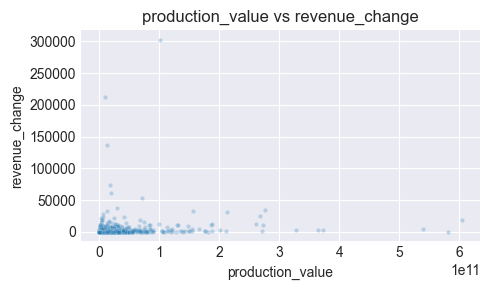

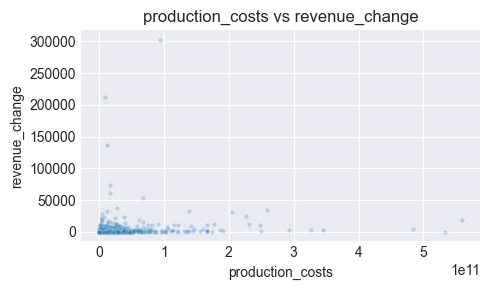

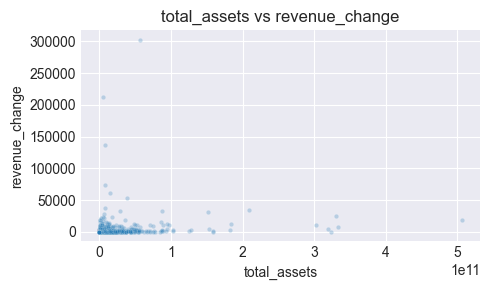

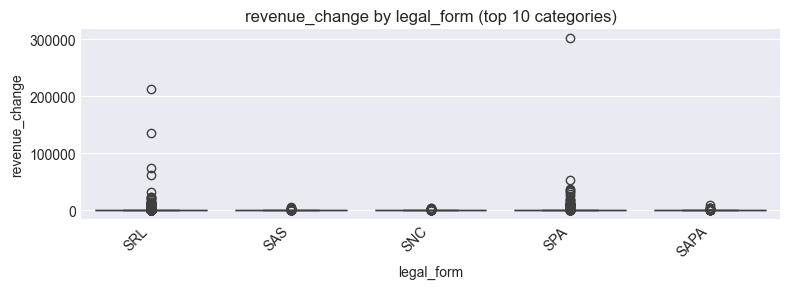

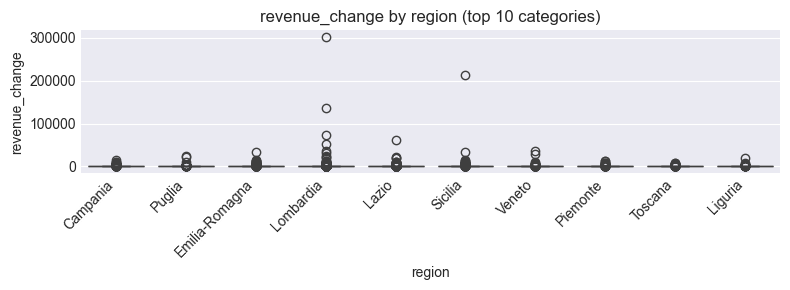

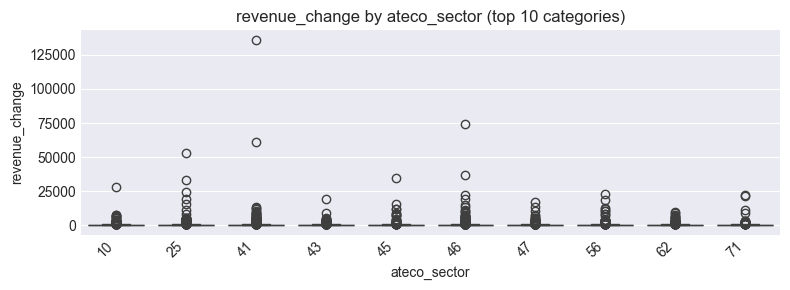

In [9]:
# Correlation of numeric features with target (Pearson and Spearman)
analysis_df = train_df.dropna(subset=[target_col])

numeric_cols = analysis_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

pearson_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col])
spearman_corr = analysis_df[numeric_features].corrwith(analysis_df[target_col], method='spearman')

corr_df = pd.DataFrame({
    'pearson': pearson_corr,
    'spearman': spearman_corr
}).sort_values('spearman', key=lambda s: s.abs(), ascending=False)

print("Top 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.head(10))

print("Bottom 10 numeric features by absolute Spearman correlation with target:")
display(corr_df.tail(10))

# Scatter plots for the top 3 features
for col in corr_df.head(3).index:
    plt.figure(figsize=(5, 3))
    sns.scatterplot(data=analysis_df, x=col, y=target_col, alpha=0.25, s=10)
    plt.title(f'{col} vs {target_col}')
    plt.tight_layout()
    save_fig(f'feature_target_scatter_{col}')
    plt.show()

# Categorical relationships with target (boxplots for top categories)
cat_cols = analysis_df.select_dtypes(include=['object']).columns.tolist()
cat_features = [c for c in cat_cols if c not in ['company_id', 'financial_health_class']]
for c in categorical_like_cols:
    if c not in cat_features:
        cat_features.append(c)

for col in [c for c in ['legal_form', 'region', 'ateco_sector'] if c in cat_features]:
    top_cats = analysis_df[col].value_counts().head(10).index
    plot_df = analysis_df[analysis_df[col].isin(top_cats)]
    plt.figure(figsize=(8, 3))
    sns.boxplot(data=plot_df, x=col, y=target_col)
    plt.title(f'{target_col} by {col} (top 10 categories)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    save_fig(f'target_by_{col}')
    plt.show()
# Analysis: diagnostics only; do not engineer features here to avoid leakage.


### 7. Multicollinearity & Redundancy


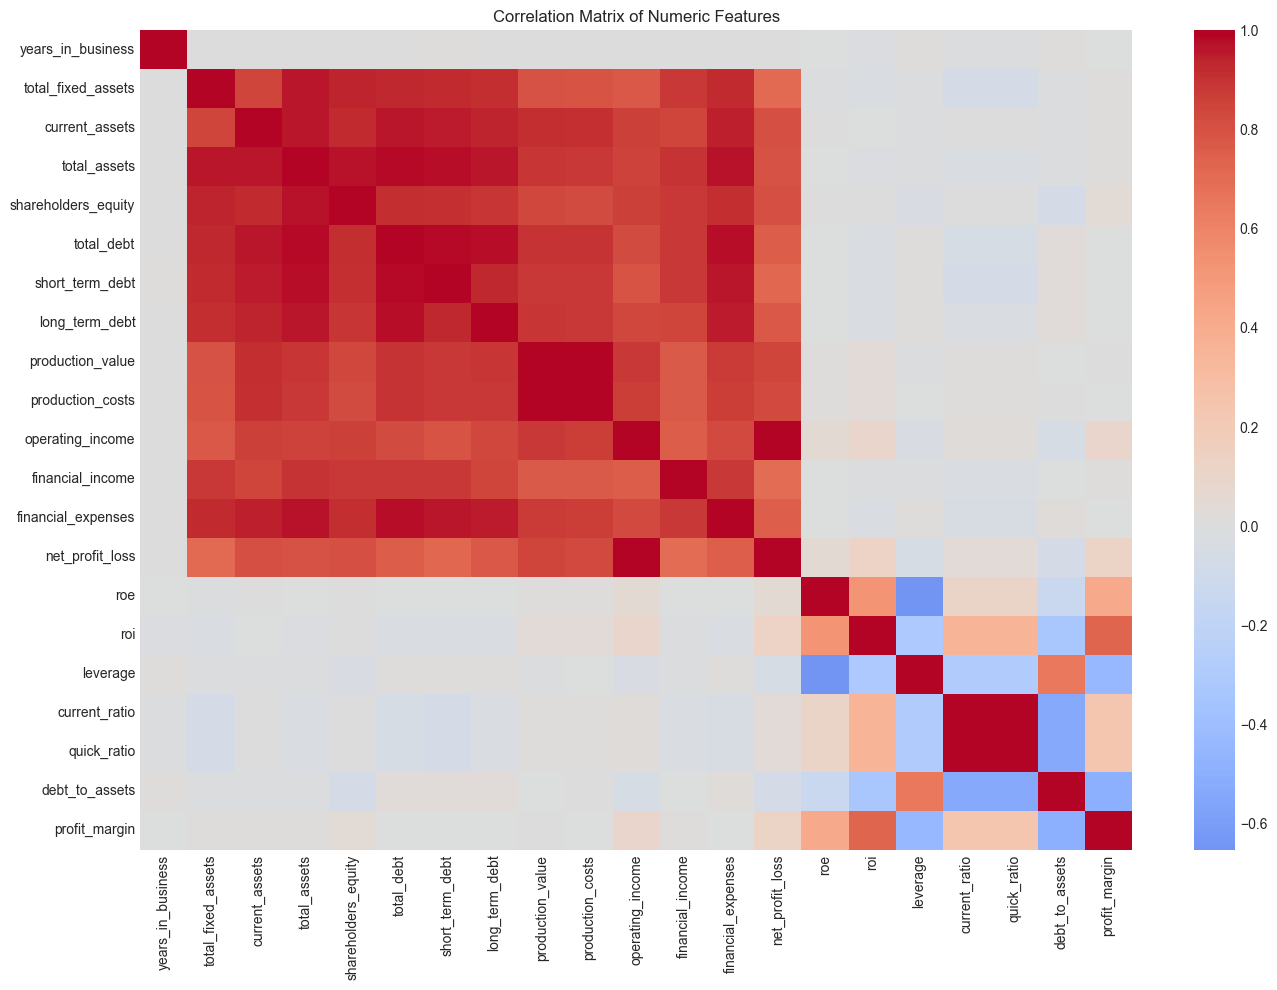

Top highly correlated feature pairs (abs corr >= 0.90):
current_ratio       quick_ratio            1.000000
production_value    production_costs       0.999147
operating_income    net_profit_loss        0.992876
total_debt          short_term_debt        0.986842
total_assets        total_debt             0.986559
total_debt          long_term_debt         0.979424
                    financial_expenses     0.975301
total_assets        short_term_debt        0.975008
                    financial_expenses     0.969726
                    shareholders_equity    0.967919
current_assets      total_assets           0.965065
total_assets        long_term_debt         0.964475
short_term_debt     financial_expenses     0.964351
current_assets      total_debt             0.960489
total_fixed_assets  total_assets           0.955742
long_term_debt      financial_expenses     0.952884
current_assets      short_term_debt        0.948981
                    financial_expenses     0.944952
total_fi

In [10]:
# TODO: Create visualizations
# - Distribution plots for key financial ratios
# - Correlation heatmap
# - Target variable by sector, region, year, etc.
# - Box plots for outlier detection

# Example: Correlation heatmap
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year'] + categorical_like_cols
numeric_features = [c for c in numeric_cols if c not in exclude_cols]

correlation_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
save_fig('correlation_heatmap')
plt.show()

# Identify highly correlated feature pairs
upper = correlation_matrix.abs().where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

high_corr_pairs = (
    upper.stack()
    .sort_values(ascending=False)
)

print("Top highly correlated feature pairs (abs corr >= 0.90):")
print(high_corr_pairs[high_corr_pairs >= 0.90].head(20))
# Analysis: high correlations suggest multicollinearity; consider regularization or pruning later.


### 8. Feature Grouping (Correlation Clustering)


Feature clusters (correlation-based):


,feature,cluster
0,operating_income,1
1,total_fixed_assets,1
2,current_assets,1
3,total_assets,1
4,shareholders_equity,1
5,total_debt,1
6,short_term_debt,1
7,long_term_debt,1
8,production_value,1
9,production_costs,1


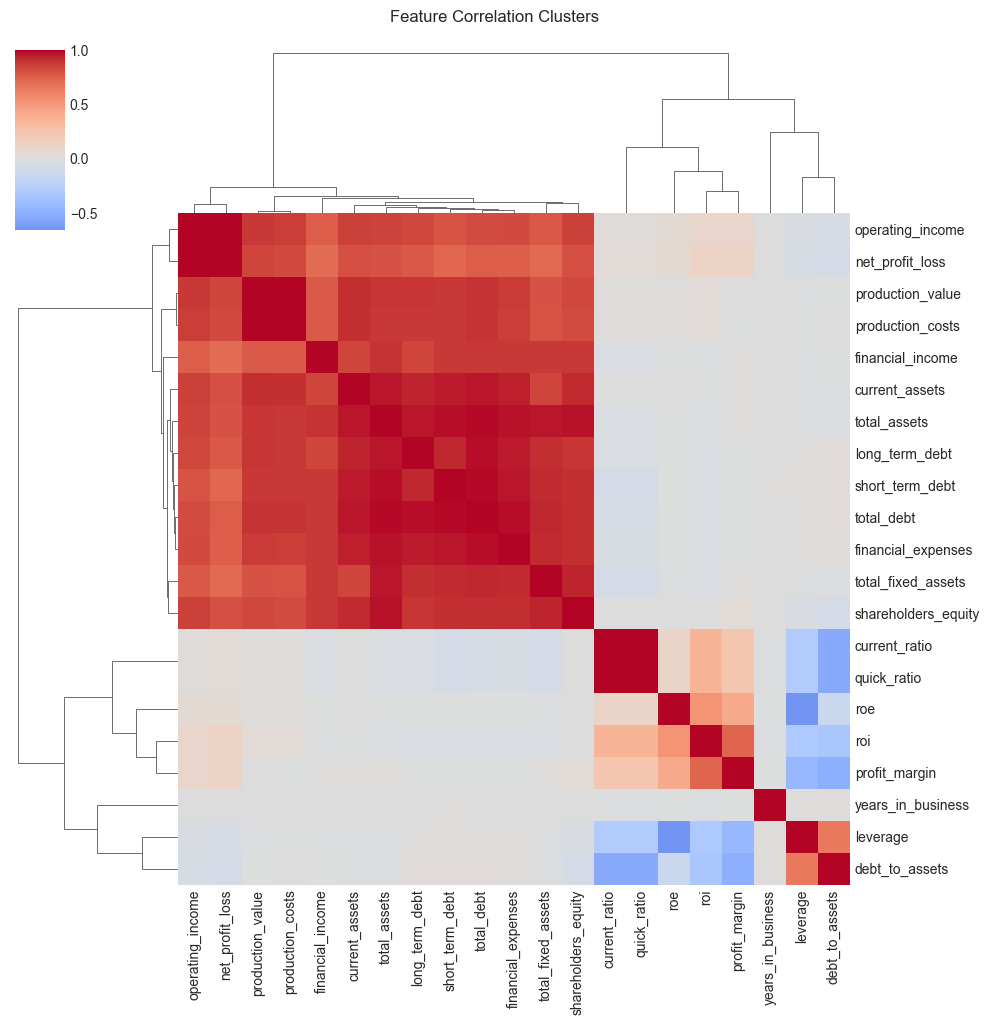

In [11]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
# ------------------------------------------------------------
# 1. Select numeric features (leakage-safe)
# ------------------------------------------------------------
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

exclude_cols = (
    ['company_id', 'fiscal_year', target_col, 'bankruptcy_next_year']
    + categorical_like_cols
)

numeric_features = [c for c in numeric_cols if c not in exclude_cols]
# ------------------------------------------------------------
# 2. Correlation matrix (EDA only)
# ------------------------------------------------------------
corr = train_df[numeric_features].corr().fillna(0)


# ------------------------------------------------------------
# 3. Absolute-correlation distance (PURE NumPy, writable)
#    distance = 1 - |corr|
# ------------------------------------------------------------
dist = (1 - corr.abs()).to_numpy(copy=True)

# ensure zero diagonal (required by squareform)
np.fill_diagonal(dist, 0)


# ------------------------------------------------------------
# 4. Hierarchical clustering
# ------------------------------------------------------------
condensed_dist = squareform(dist)

linkage_matrix = linkage(condensed_dist, method="average")


# ------------------------------------------------------------
# 5. Cluster assignment
#    t=0.30  => |corr| >= 0.70 grouped together
# ------------------------------------------------------------
cluster_labels = fcluster(
    linkage_matrix,
    t=0.30,
    criterion="distance"
)

cluster_map = (
    pd.DataFrame({
        "feature": corr.columns,
        "cluster": cluster_labels
    })
    .sort_values("cluster")
    .reset_index(drop=True)
)

print("Feature clusters (correlation-based):")
display(cluster_map)


# ------------------------------------------------------------
# 6. Optional visualization (EDA only)
# ------------------------------------------------------------
g = sns.clustermap(
    corr,
    cmap="coolwarm",
    center=0,
    figsize=(10, 10)
)
plt.suptitle("Feature Correlation Clusters", y=1.02)
g.savefig(IMAGES_DIR / 'feature_correlation_clusters.png', dpi=150, bbox_inches='tight')
plt.show()


# ------------------------------------------------------------
# 7. Interpretation note (for report / defense)
# ------------------------------------------------------------
# Clusters identify groups of highly correlated features.
# These indicate redundancy and motivate:
# - feature grouping,
# - representative feature selection,
# - or regularization (Ridge / ElasticNet).

### 9. Data Leakage Audit (Mandatory)


In [12]:
# Potential leakage checks

# 1) Explicit target columns
leakage_targets = ['revenue_change', 'bankruptcy_next_year', 'financial_health_class']
print("Potential leakage targets present:", [c for c in leakage_targets if c in train_df.columns])

# 2) Columns with suspicious names
suspicious_patterns = ['next', 'future', 'target', 'label']
suspect_cols = [c for c in train_df.columns if any(pat in c.lower() for pat in suspicious_patterns)]
print("Suspicious name-based columns:", suspect_cols)

# 3) Duplicate company-year rows
dup_count = train_df.duplicated(subset=['company_id', 'fiscal_year']).sum()
print(f"Duplicate company_id + fiscal_year rows: {dup_count}")

# 4) Target availability by year (expected: missing in first year per company)
missing_target_by_year = train_df.groupby('fiscal_year')[target_col].apply(lambda s: s.isna().mean())
print("Missing target rate by fiscal_year:")
print(missing_target_by_year)

# 5) Features that are deterministic functions of the target (none expected here)
# Note: revenue_change is derived from production_value_t and production_value_{t-1},
# which are available at prediction time if using only historical data.

print("Leakage audit summary:")
print("- Exclude other targets from features (bankruptcy_next_year, financial_health_class).")
print("- Split by fiscal_year to prevent temporal leakage.")
print("- Drop rows with missing target AFTER splitting (to avoid using future info).")
# Analysis: ensure other targets excluded and temporal splits enforced in modeling.


Potential leakage targets present: ['revenue_change', 'bankruptcy_next_year', 'financial_health_class']
Suspicious name-based columns: ['bankruptcy_next_year']
Duplicate company_id + fiscal_year rows: 0
Missing target rate by fiscal_year:
fiscal_year
2018    1.000000
2019    0.012756
2020    0.000000
2021    0.000000
Name: revenue_change, dtype: float64
Leakage audit summary:
- Exclude other targets from features (bankruptcy_next_year, financial_health_class).
- Split by fiscal_year to prevent temporal leakage.
- Drop rows with missing target AFTER splitting (to avoid using future info).


### 10. EDA -> Modeling Implications

- Highly skewed target suggests robust metrics (MAE/MAPE), potential target transformation, and outlier-aware loss.
- Missing target in the first fiscal year implies we should exclude those rows during model training only.
- Sparse missingness in a few features suggests simple imputation with missing indicators may suffice.
- High multicollinearity among financial totals suggests regularization (Ridge/Lasso) or tree-based models.
- Strong size-related correlations indicate scaling and potential use of ratios or normalized features.
- Categorical features are low-cardinality (except company_id), suitable for one-hot encoding.


## Key EDA Conclusions

- Dataset: 11,828 rows, 30 columns, 2,999 companies, fiscal years 2018-2021.
- Target `revenue_change` has 2,999 missing values (expected for first year) and is extremely right-skewed with heavy tails.
- Only a few features have missingness (notably `province`, `leverage`, `roe`), suggesting focused imputation.
- `ateco_sector` is numeric-coded but should be treated as categorical; `company_id` is a high-cardinality identifier.
- Strong multicollinearity exists among balance sheet totals and ratios (e.g., total_assets vs total_debt, current_ratio vs quick_ratio).
- Outliers are prevalent in key financial amounts, so robust preprocessing is likely required.
- Leakage risk: other targets (`bankruptcy_next_year`, `financial_health_class`) must be excluded; temporal splits are mandatory.


## 3. Data Preprocessing

Handle missing values, outliers, and prepare data for modeling.

In [13]:
# Create a copy for preprocessing
df_processed = train_df.copy()

# TODO: Handle missing values
# - Decide on imputation strategy (median, mean, by group, etc.)
# - Document your rationale

# TODO: Handle outliers
# - Identify outliers (IQR, winsorization, etc.)
# - Decide on treatment strategy

# TODO: Encode categorical variables
# - One-hot encoding, label encoding, etc.

print("Preprocessing complete!")

Preprocessing complete!


In [14]:
# Train/Validation split
# IMPORTANT: Use temporal split, not random!

# For Challenges 1 & 2:
# train_years = [2018, 2019, 2020]
# val_year = 2021

# For Challenge 3 (time series):
# train_years = [2018, 2019]
# val_year = 2020
# test_year = 2021

# TODO: Implement temporal split
# df_train = df_processed[df_processed['fiscal_year'].isin(train_years)]
# df_val = df_processed[df_processed['fiscal_year'] == val_year]

print("Train/validation split complete!")

Train/validation split complete!


In [15]:
# Feature scaling
# IMPORTANT: Fit scaler on training data only!

from sklearn.preprocessing import StandardScaler, RobustScaler

# TODO: Choose and apply scaler
# scaler = StandardScaler()  # or RobustScaler() for outlier resistance
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

print("Feature scaling complete!")

Feature scaling complete!


## 4. Feature Engineering

Create new features based on domain knowledge.

In [16]:
# TODO: Engineer features
# Ideas:
# - Financial ratios (if not already present)
# - Year-over-year changes (growth rates)
# - Interaction features
# - Altman Z-Score or similar bankruptcy models
# - Sector-relative features (company vs sector average)
# - Temporal features (trends, volatility)

# Example: Year-over-year change
# df_processed = df_processed.sort_values(['company_id', 'fiscal_year'])
# df_processed['roe_yoy_change'] = df_processed.groupby('company_id')['roe'].diff()

print("Feature engineering complete!")
print(f"Total features: {df_processed.shape[1]}")

Feature engineering complete!
Total features: 30


**Engineered Features:**

TODO: List and explain your engineered features
1. 
2. 
3. 

## 5. Model Development

Train multiple models and compare performance.

In [17]:
# Import models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, roc_auc_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from xgboost import XGBClassifier, XGBRegressor

# For handling class imbalance (Challenges 1 & 2)
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

print("Model libraries imported!")

Model libraries imported!


In [18]:
# TODO: Prepare X and y
# feature_cols = [...]  # List your feature columns
# target_col = 'bankruptcy_next_year'  # or 'financial_health_class' or 'revenue_change'

# X_train = df_train[feature_cols]
# y_train = df_train[target_col]
# X_val = df_val[feature_cols]
# y_val = df_val[target_col]

print("Data prepared for modeling!")

Data prepared for modeling!


### Baseline Model

In [19]:
# TODO: Train baseline model
# For classification: Logistic Regression
# For regression: Linear Regression

# Example for Challenge 1 (Bankruptcy):
# baseline_model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
# baseline_model.fit(X_train_scaled, y_train)
# y_pred_baseline = baseline_model.predict(X_val_scaled)

# print("Baseline Model Performance:")
# print(classification_report(y_val, y_pred_baseline))
# print(f"F1-Score: {f1_score(y_val, y_pred_baseline):.4f}")

### Advanced Models

In [20]:
# TODO: Train multiple models
# - Random Forest
# - XGBoost
# - Gradient Boosting
# - etc.

# For classification with imbalance, consider:
# - SMOTE oversampling
# - Class weights
# - Threshold tuning

# Example for Random Forest with SMOTE:
# smote = SMOTE(random_state=RANDOM_STATE)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# rf_model = RandomForestClassifier(
#     n_estimators=100,
#     max_depth=10,
#     random_state=RANDOM_STATE
# )
# rf_model.fit(X_train_resampled, y_train_resampled)

print("Advanced models trained!")

Advanced models trained!


In [21]:
# TODO: Hyperparameter tuning
# Use GridSearchCV or RandomizedSearchCV

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Example:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10]
# }

# grid_search = GridSearchCV(
#     RandomForestClassifier(random_state=RANDOM_STATE),
#     param_grid,
#     cv=StratifiedKFold(n_splits=5),
#     scoring='f1',
#     n_jobs=-1
# )
# grid_search.fit(X_train_scaled, y_train)
# best_model = grid_search.best_estimator_

print("Hyperparameter tuning complete!")

Hyperparameter tuning complete!


## 6. Model Evaluation

Compare models and select the best one.

In [22]:
# TODO: Create model comparison table
# Compare all models on validation set using appropriate metrics

# For Challenge 1: F1-Score, AUC-ROC, Precision, Recall
# For Challenge 2: Weighted F1, Macro F1, Accuracy, Confusion Matrix
# For Challenge 3: RMSE, MAE, MAPE, R², Directional Accuracy

# Example comparison:
# models_comparison = pd.DataFrame({
#     'Model': ['Baseline', 'Random Forest', 'XGBoost'],
#     'F1-Score': [...],
#     'AUC-ROC': [...],
#     'Precision': [...],
#     'Recall': [...]
# })
# print(models_comparison)

In [23]:
# TODO: Confusion Matrix (for classification)
# from sklearn.metrics import ConfusionMatrixDisplay

# ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('Confusion Matrix - Best Model')
# plt.show()

In [24]:
# TODO: ROC Curve (for binary classification)
# from sklearn.metrics import RocCurveDisplay

# RocCurveDisplay.from_estimator(best_model, X_val_scaled, y_val)
# plt.title('ROC Curve - Best Model')
# plt.show()

**Model Selection:**

TODO: Justify your final model choice
- 
- 

## 7. Interpretation and Business Insights

Explain the model and extract business value.

In [25]:
# TODO: Feature Importance
# For tree-based models, use built-in feature importance
# For other models, consider SHAP values

# Example:
# feature_importance = pd.DataFrame({
#     'feature': feature_cols,
#     'importance': best_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
# plt.xlabel('Importance')
# plt.title('Top 15 Most Important Features')
# plt.gca().invert_yaxis()
# plt.tight_layout()
# plt.show()

In [26]:
# TODO: Error Analysis
# - Which cases does the model misclassify/mispredicts?
# - Are there patterns in the errors?
# - How do errors vary by sector, size, region, etc.?

# Example:
# errors_df = df_val.copy()
# errors_df['prediction'] = y_pred
# errors_df['error'] = (errors_df['prediction'] != errors_df[target_col])

# print("Error rate by sector:")
# print(errors_df.groupby('ateco_sector')['error'].mean().sort_values(ascending=False))

**Business Insights:**

TODO: Translate technical findings into business language

**Key Risk Factors** (for bankruptcy/health challenges):
1. 
2. 
3. 

**Revenue Drivers** (for forecasting challenge):
1. 
2. 
3. 

**Actionable Recommendations:**
- 
- 
- 

## 8. Conclusions and Future Work

Summarize findings and discuss limitations.

**Summary:**

TODO: Summarize your work
- 
- 

**Performance vs Targets:**

TODO: Compare your results to challenge targets
- My F1-Score: [X.XX] vs Target: [0.55-0.70]
- ...

**Model Limitations:**

TODO: Discuss limitations honestly
1. 
2. 
3. 

**Future Improvements:**

TODO: What would you do with more time?
1. 
2. 
3. 

**Lessons Learned:**

TODO: Reflect on the experience
- 
- 

---

## Final Checklist

Before submitting, verify:

- [ ] All code cells execute without errors
- [ ] Markdown cells explain each step clearly
- [ ] Visualizations are clear and labeled
- [ ] Feature importance is analyzed
- [ ] Error analysis is performed
- [ ] Business insights are provided
- [ ] Model limitations are discussed
- [ ] Code is well-commented
- [ ] Results meet or exceed minimum performance targets
- [ ] No data leakage (temporal split, proper scaling, etc.)
- [ ] Citations for any external code/resources

**Good luck with your challenge!** 🚀